In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import lbg_forecast.priors_gp_dust as gpdp
import scipy as sc
import lbg_forecast.utils as utils
import lbg_forecast.dust_curves as dc


def join_selected_spsp(nruns, selected_spsp):

    tot_arr = []
    for d in range(3):
        arr = []
        for i in range(nruns):
            arr.append(np.squeeze(selected_spsp[i][0][d]))

        tot_arr.append(np.vstack(arr))

    combined_arr =  np.array(tot_arr, dtype='object')

    return combined_arr

def join_nz(nruns, nzs):

    tot_arr = []
    for d in range(3):
        arr = []
        for i in range(nruns):
            arr.append(nzs[i][d])

        tot_arr.append(np.hstack(arr))

    combined_arr =  np.array(tot_arr, dtype='object')

    return combined_arr

In [6]:
nruns=2
run='nag_mean'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
sparams = []
ndens = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))

spsp_nag = np.vstack(np.squeeze(spsp))
selected_spsp_nag = join_selected_spsp(nruns, selected_spsp)
nzs_nag = join_nz(nruns, np.vstack(nzs))

In [2]:
nruns=2
run='irac_mean'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
sparams = []
ndens = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))


spsp_irac = np.vstack(np.squeeze(spsp))
selected_spsp_irac = join_selected_spsp(nruns, selected_spsp)
nzs_irac = join_nz(nruns, np.vstack(nzs))


In [3]:
nruns=2
run='cosmos_mean'
extra=True
spsp = []
selected_spsp = []
photometry = []
nzs = []
sparams = []
ndens = []
for i in range(nruns):
    spsp.append(np.load("sps_parameter_samples/sps_"+run+"_"+str(i)+".npy"))
    selected_spsp.append(np.load("sps_parameter_samples/selected_sps_"+run+"_"+str(i)+".npy", allow_pickle=True))
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))


spsp_cosmos = np.vstack(np.squeeze(spsp))
selected_spsp_cosmos = join_selected_spsp(nruns, selected_spsp)
nzs_cosmos = join_nz(nruns, np.vstack(nzs))

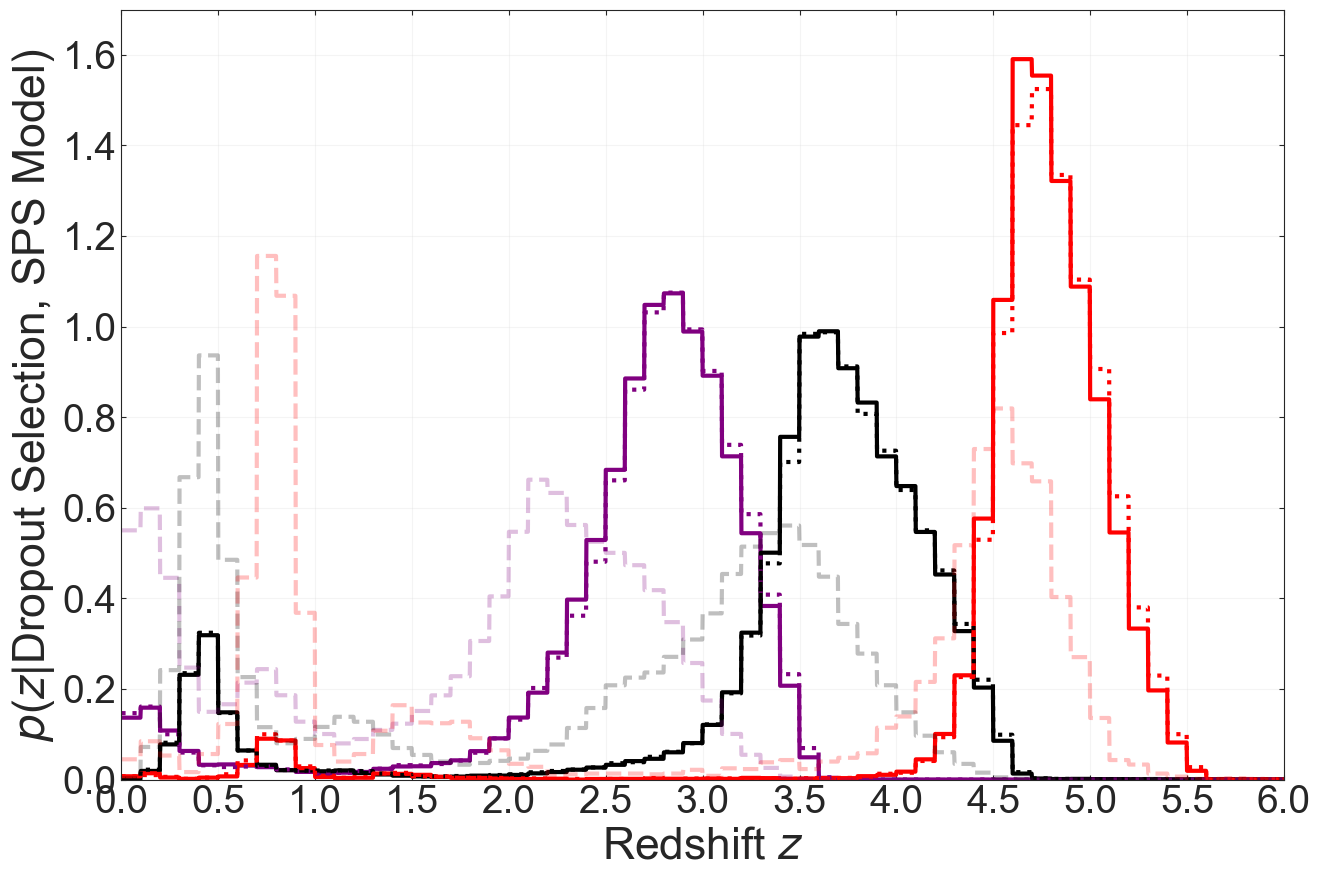

In [12]:
def plot_nzs(axes, nzs, density, a, ls, model, **kwargs):

    ndropouts = 3

    bin_step = 0.1
    bin_start = 0
    bin_end = 7

    bins = np.arange(bin_start, bin_end, bin_step)
    colours = ['purple', 'black', 'red']


    samples=50
    grid = np.arange(bin_start, bin_end-bin_step, bin_step/samples)

    for drop in range(ndropouts):

        values = []
        for ind in range(nzs.shape[0]):
            hist = np.histogram(nzs[ind][drop], density=density, bins=bins)
            oversampled_values = np.repeat(hist[0], samples)
            values.append(oversampled_values)

        values = np.vstack((np.array(values)))
        mean_at_grid_point = np.mean(values, axis=0)
        if(drop == 0):
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, label=model, ls=ls, alpha=a)
        else:
            axes.plot(grid, mean_at_grid_point, c=colours[drop], **kwargs, ls=ls, alpha=a)


    #axes.legend(fontsize=18, ncol=3, loc='upper left')
    axes.set_xlabel("Redshift $z$", fontsize=32)
    axes.set_ylabel("$p$($z$|Dropout Selection, SPS Model)", fontsize=32)
    axes.set_xticks(np.arange(0, 7, 0.5))
    axes.tick_params('x', labelsize=28)
    axes.tick_params('y', labelsize=28)
    axes.grid(alpha=0.2)
    axes.set_xlim(0, 6)
    axes.set_ylim(0, 1.7)


density=True
fig1, axes = plt.subplots(1, 1, figsize=(15,10), sharex=False, sharey=False)
plot_nzs(axes, np.array([nzs_cosmos]), density=density, a=1.0, ls='-', model='Alsing+24', lw=3)
plot_nzs(axes, np.array([nzs_irac]), density=density, a=1.0, ls=':', model='Thorp+25', lw=3)
plot_nzs(axes, np.array([nzs_nag]), density=density, a=0.25, ls='--', model='Nagaraj+22', lw=3)

In [69]:
def get_sfr_tau2(spsp, xl, xh, ngrid, cut=99999999):

    _, tau_2, _, _, _ = pop.get_dust_params_from_pop(spsp, cut=cut)
    recent_sfrs = pop.get_sfr_params_from_pop(spsp, cut=cut)

    return utils.process_samples_median(recent_sfrs, tau_2, xl, xh, ngrid)

def get_sfr_tau_uv(spsp, xl, xh, ngrid, cut=99999999):

    _, _, _, tau_uv, _ = pop.get_dust_params_from_pop(spsp, cut=cut)

    redshift  = spsp[:cut, 0]
    logmass  = np.log10(spsp[:cut, -1])
    sfrsratios = spsp[:, 10:-1]

    recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshift, 10**logmass, sfrsratios))

    return utils.process_samples_median(recent_sfrs, tau_uv, xl, xh, ngrid)

def get_fuv_slopes(spsp, xl, xh, ngrid, cut=999999999):

    tau1, tau2, index, _, _ = pop.get_dust_params_from_pop(spsp, cut=cut)
    slopes = dc.uv_slope(tau1, tau2, index)
    av = dc.total_attenuation(5500, dc.tau_to_a(tau1), dc.tau_to_a(tau2), index)

    return utils.process_samples_median(av, slopes, xl, xh, ngrid)

In [61]:
def plot_all(spsp, selected_spsp):
    indx=0
    ux, uy, uy025, uy975, uy16, uy84 = get_sfr_tau_uv(selected_spsp[0], -5, 3, 15)
    gx, gy, gy025, gy975, gy16, gy84 = get_sfr_tau_uv(selected_spsp[1], -5, 3, 15)
    rx, ry, ry025, ry975, ry16, ry84 = get_sfr_tau_uv(selected_spsp[2], -5, 3, 15)
    x, y, y025, y975, y16, y84 = get_sfr_tau_uv(spsp, -5, 5, 15, cut=10000)

    plt.plot(ux,uy, color='purple', ls='--', lw=2, label='u dropouts')
    plt.plot(gx,gy, color='k', ls='-.', lw=2, label='g dropouts')
    plt.plot(rx,ry, color='red', ls='-', lw=2, label='r dropouts')
    plt.plot(x, y, color='blue', ls=':', lw=2, label='Total galaxy population')

    plt.fill_between(ux, uy025, uy975, alpha=0.05, color='purple')
    plt.fill_between(gx, gy025, gy975, alpha=0.05, color='k')
    plt.fill_between(rx, ry025, ry975, alpha=0.05, color='red')
    plt.fill_between(x, y025, y975, alpha=0.05, color='blue', hatch='.')

    plt.fill_between(ux, uy16, uy84, alpha=0.15, color='purple')
    plt.fill_between(gx, gy16, gy84, alpha=0.15, color='k')
    plt.fill_between(rx, ry16, ry84, alpha=0.15, color='red')
    plt.fill_between(x, y16, y84, alpha=0.15, color='blue', hatch='.')


def plot_total(spsp, colour, label, xl, xh, ngrid, ls, hatch=None):

    x, y, y025, y975, y16, y84 = get_sfr_tau_uv(spsp, xl, xh, ngrid, cut=10000)
    plt.plot(x, y, color=colour, lw=3, ls=ls)


    if(hatch!=None):
        plt.fill_between(x, y025, y975, alpha=0.05, color=colour, hatch=hatch)
        plt.fill_between(x, y16, y84, alpha=0.15, color=colour, hatch=hatch, label=label)
    else:
        plt.fill_between(x, y025, y975, alpha=0.05, color=colour)
        plt.fill_between(x, y16, y84, alpha=0.15, color=colour, label=label)

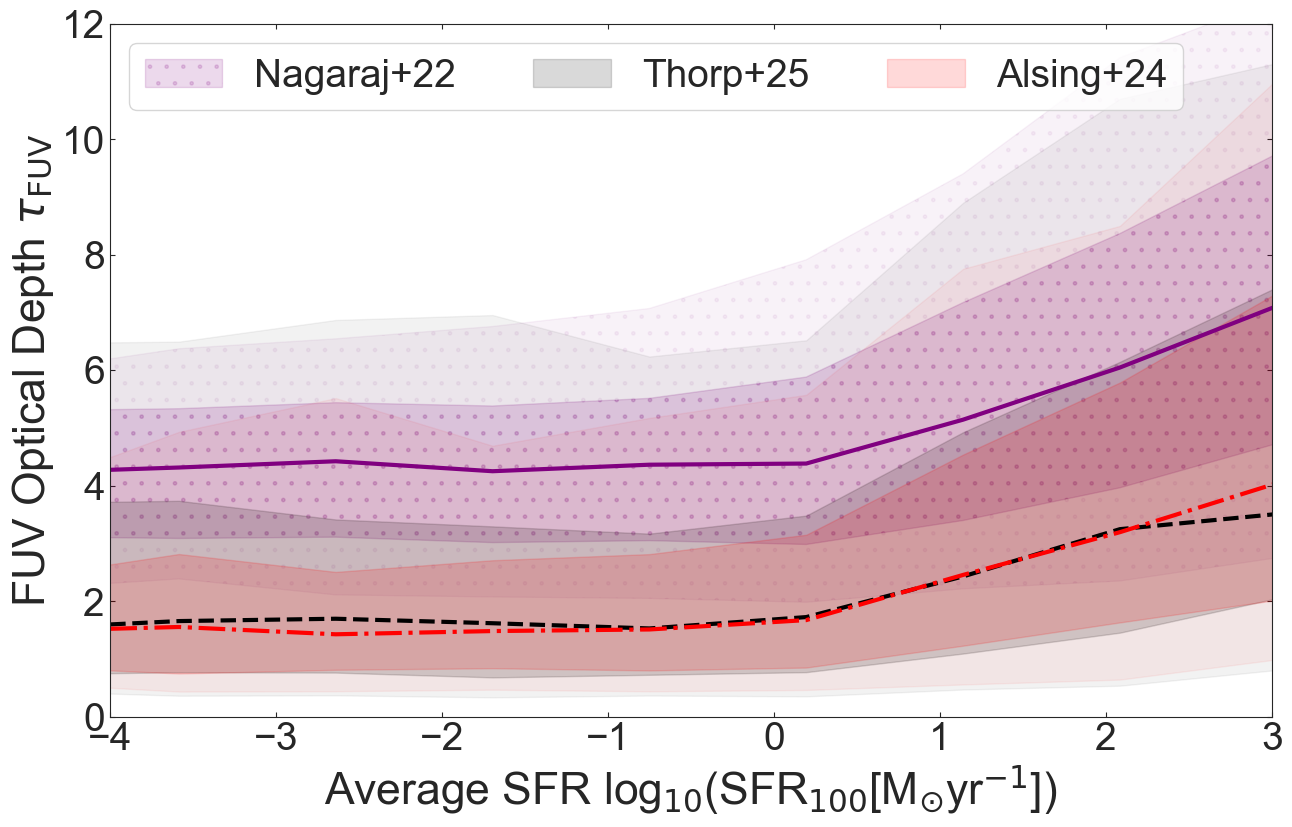

In [85]:
plot_total(spsp_nag, 'purple', 'Nagaraj+22', -5, 3.5, 10, hatch='.', ls='-')
plot_total(spsp_irac, 'black', 'Thorp+25', -5, 3.5, 10, ls='--')
plot_total(spsp_cosmos, 'red', 'Alsing+24', -5, 3.5, 10, ls='-.')
plt.ylim(0, 12)
plt.xlim(-4, 3)

fig = plt.gcf()
fig.set_size_inches(15, 9)

fs=32
ls=28

plt.tick_params('x', labelsize=ls)
plt.tick_params('y', labelsize=ls)

plt.xlabel('Average SFR log$_{10}$(SFR$_{100}$[M$_{\odot}$yr$^{-1}$])', fontsize=fs)
plt.ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper left', fontsize=ls, ncol=3)


#trying to find scaling between tau2 and tau_fuv
#xt2, yt2, y025t2, y975t2, y16t2, y84t2 = get_sfr_tau2(spsp_cosmos, -5, 3.5, 10, cut=10000)
#xt2nag, yt2nag, y025t2nag, y975t2nag, y16t2nag, y84t2nag = get_sfr_tau2(spsp_nag, -5, 3.5, 10, cut=10000)
#xt2i, yt2i, y025t2i, y975t2i, y16t2i, y84t2i = get_sfr_tau2(spsp_irac, -5, 3.5, 10, cut=10000)


#ax1=plt.gca()
#ax2 = ax1.twinx()
#ax2.plot(xt2, yt2)
#ax2.plot(xt2nag, yt2nag)
#ax2.plot(xt2i, yt2i)
#ax2.set_ylim(0, 1.71)

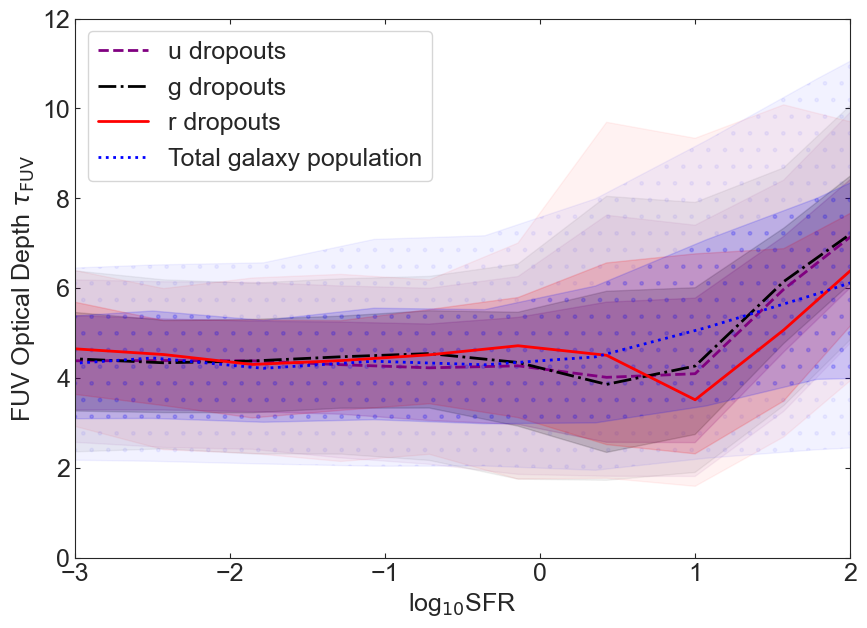

In [9]:
plot_all(spsp_nag, selected_spsp_nag)

plt.ylim(0, 12)
plt.xlim(-3, 2)

fig = plt.gcf()
fig.set_size_inches(10, 7)

fs=18

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)


plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

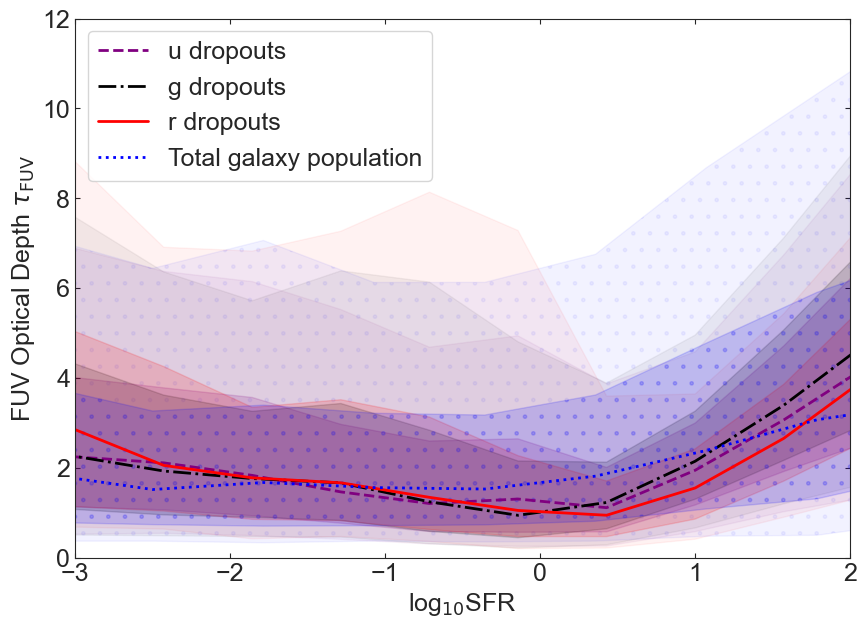

In [10]:
plot_all(spsp_irac, selected_spsp_irac)

plt.ylim(0, 12)
plt.xlim(-3, 2)

fig = plt.gcf()
fig.set_size_inches(10, 7)

fs=18

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

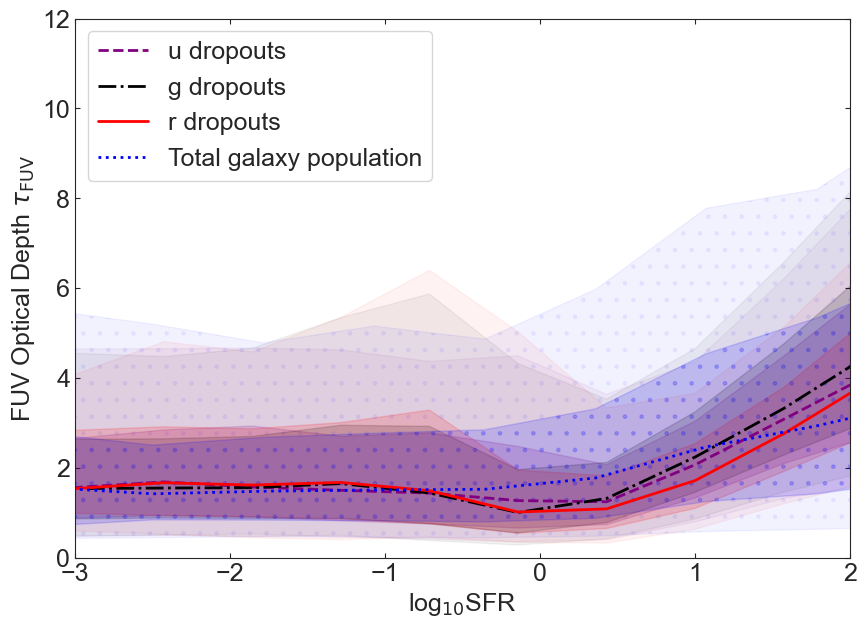

In [11]:
plot_all(spsp_cosmos, selected_spsp_cosmos)

plt.ylim(0, 12)
plt.xlim(-3, 2)

fig = plt.gcf()
fig.set_size_inches(10, 7)

fs=18

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

In [44]:
def plt_sfr_hist(spsp, selected_spsp, axis=None, cut=999999999):

    recent_sfrs = pop.get_sfr_params_from_pop(spsp, cut = cut)

    recent_sfrs_u = pop.get_sfr_params_from_pop(selected_spsp[0])
    recent_sfrs_g = pop.get_sfr_params_from_pop(selected_spsp[1])
    recent_sfrs_r = pop.get_sfr_params_from_pop(selected_spsp[2])

    bins = np.linspace(-8, 4, 50)

    if(axis==None):
        plt.hist(recent_sfrs, density=True, alpha=0.2, bins=bins, label='Total galaxy population', hatch='.')
        plt.hist(recent_sfrs_u, density=True, alpha=0.2, bins=bins, color='purple', label='u dropouts')
        plt.hist(recent_sfrs_g, density=True, alpha=0.2, bins=bins, color='k', label='g dropouts')
        plt.hist(recent_sfrs_r, density=True, alpha=0.2, bins=bins, color='red', label='r dropouts')
    else:
        axis.hist(recent_sfrs, density=True, alpha=0.2, bins=bins, label='Total galaxy population', hatch='.')
        axis.hist(recent_sfrs_u, density=True, alpha=0.2, bins=bins, color='purple', label='u dropouts')
        axis.hist(recent_sfrs_g, density=True, alpha=0.2, bins=bins, color='k', label='g dropouts')
        axis.hist(recent_sfrs_r, density=True, alpha=0.2, bins=bins, color='red', label='r dropouts')


def plt_sfr_total(cut=999999999):

    recent_nag = pop.get_sfr_params_from_pop(spsp_nag, cut = cut)
    recent_irac = pop.get_sfr_params_from_pop(spsp_irac, cut = cut)
    recent_cosmos = pop.get_sfr_params_from_pop(spsp_cosmos, cut = cut)

    bins = np.linspace(-8, 4, 50)

    plt.hist(recent_nag, density=True, alpha=0.2, bins=bins, color='purple', label='Nagaraj+22', hatch='.')
    plt.hist(recent_irac, density=True, alpha=0.2, bins=bins, color='k', label='Thorp+25')
    plt.hist(recent_cosmos, density=True, alpha=0.2, bins=bins, color='red', label='Alsing+24')

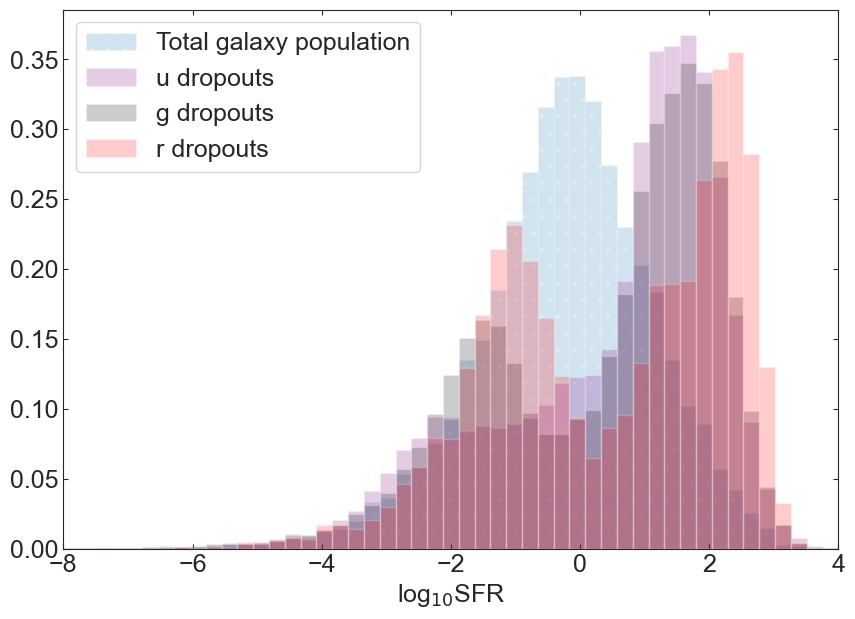

In [13]:
plt_sfr_hist(spsp_nag, selected_spsp_nag, cut=10000)

plt.xlim(-8, 4)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

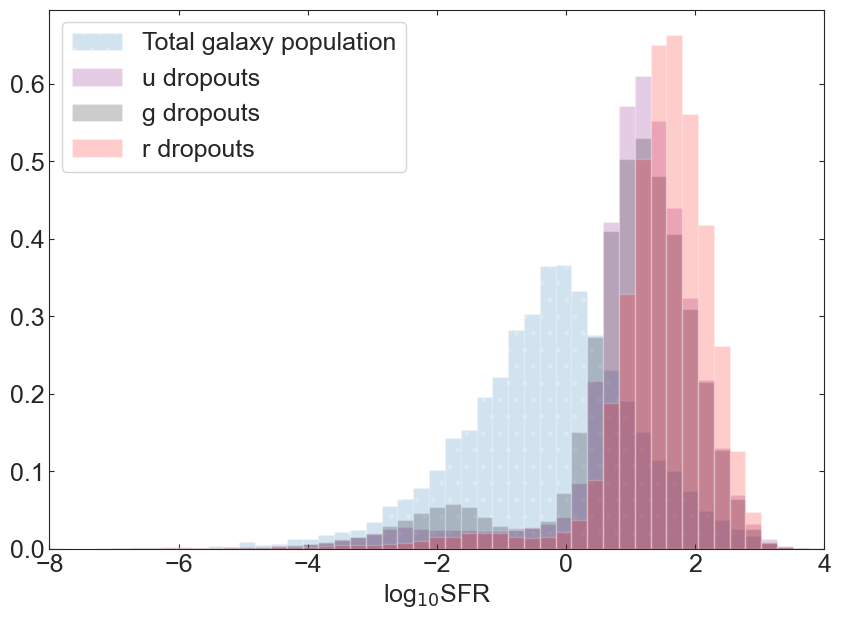

In [14]:
plt_sfr_hist(spsp_irac, selected_spsp_irac, cut=10000)

plt.xlim(-8, 4)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

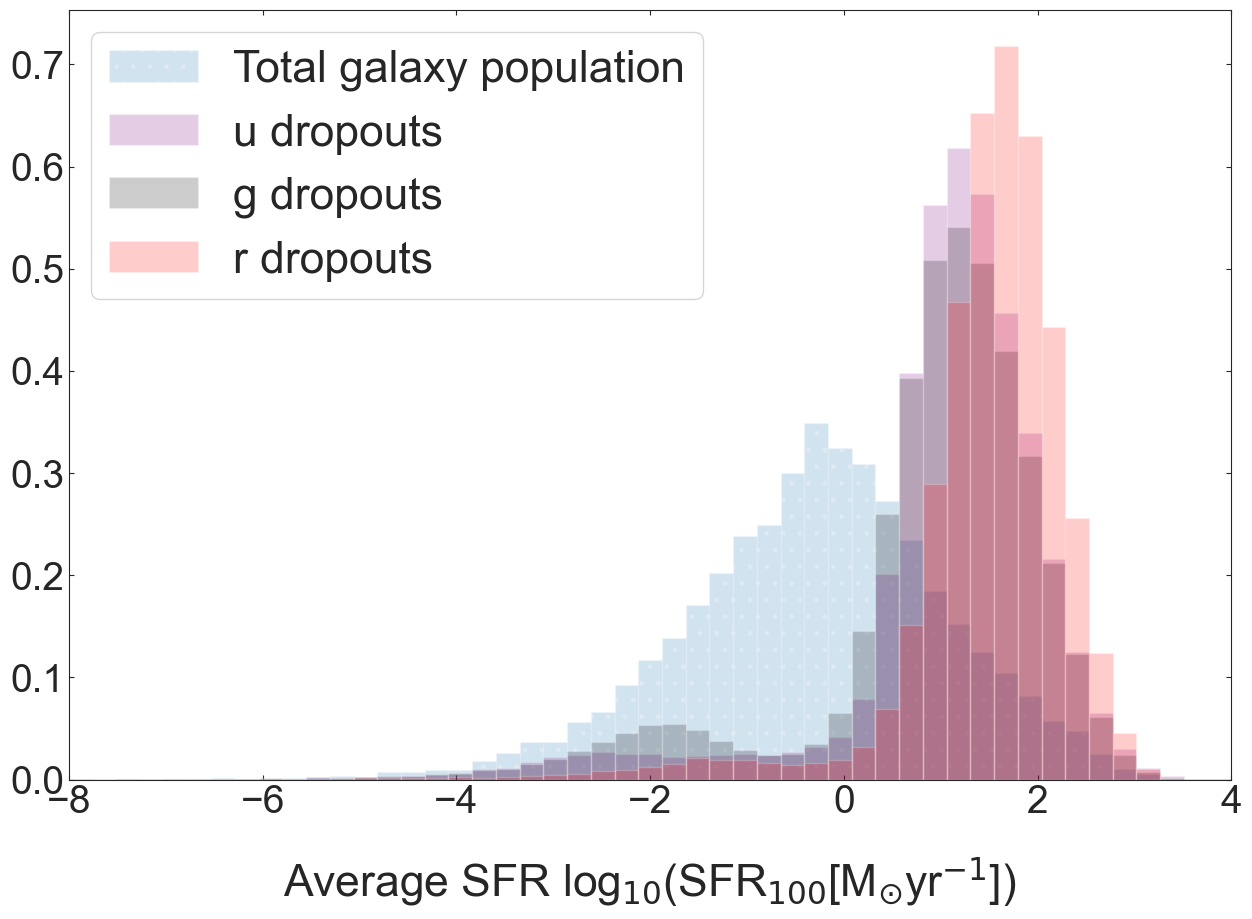

In [15]:
plt_sfr_hist(spsp_cosmos, selected_spsp_cosmos, cut=10000)

fs=32
ls=28

fig = plt.gcf()
fig.set_size_inches(15, 10)

ax=plt.gca()

ax.tick_params('x', labelsize=ls)
ax.tick_params('y', labelsize=ls)

ax.set_xlim(-8, 4)

ax.set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[M$_{\odot}$yr$^{-1}$])', fontsize=fs, labelpad=25)
ax.legend(loc='upper left', fontsize=fs, ncol=1)
#ax.set_ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)

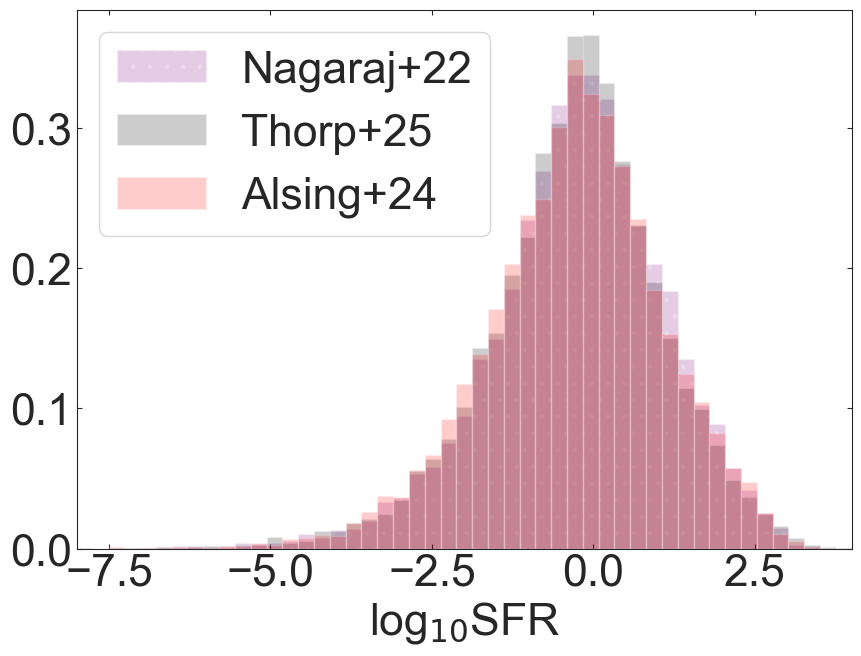

In [16]:
plt_sfr_total(cut=10000)


plt.xlim(-8, 4)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('log$_{10}$SFR', fontsize=fs)
plt.legend(loc='upper left', fontsize=fs, ncol=1)

In [17]:
def plot_tau_hist(spsp, selected_spsp, cut=999999999):

    indx=0
    _, _, _, tau_uv, _ = pop.get_dust_params_from_pop(spsp, cut=cut)

    _, _, _, tau_uv_u, _ = pop.get_dust_params_from_pop(selected_spsp[0])
    _, _, _, tau_uv_g, _ = pop.get_dust_params_from_pop(selected_spsp[1])
    _, _, _, tau_uv_r, _ = pop.get_dust_params_from_pop(selected_spsp[2])

    bins = np.linspace(0, 15, 50)

    plt.hist(tau_uv, density=True, alpha=0.2, bins=bins, label='Total galaxy population', hatch='.')
    plt.hist(tau_uv_u, density=True, alpha=0.2, bins=bins, color='purple', label='u dropouts')
    plt.hist(tau_uv_g, density=True, alpha=0.2, bins=bins, color='k', label='g dropouts')
    plt.hist(tau_uv_r, density=True, alpha=0.2, bins=bins, color='red', label='r dropouts')

def plot_tau_total(cut=999999999):
    indx=0
    _, _, _, tau_uv_nag, _ = pop.get_dust_params_from_pop(spsp_nag, cut=cut)
    _, _, _, tau_uv_irac, _ = pop.get_dust_params_from_pop(spsp_irac, cut=cut)
    _, _, _, tau_uv_cosmos, _ = pop.get_dust_params_from_pop(spsp_cosmos, cut=cut)

    bins = np.linspace(0, 15, 50)

    h = plt.hist(tau_uv_nag, density=True, alpha=0.2, bins=bins, color='purple', label='Nagaraj+22', hatch='.')
    h = plt.hist(tau_uv_irac, density=True, alpha=0.2, bins=bins, color='k', label='Thorp+25')
    h = plt.hist(tau_uv_cosmos, density=True, alpha=0.2, bins=bins, color='red', label='Alsing+24')

(0.0, 0.45)

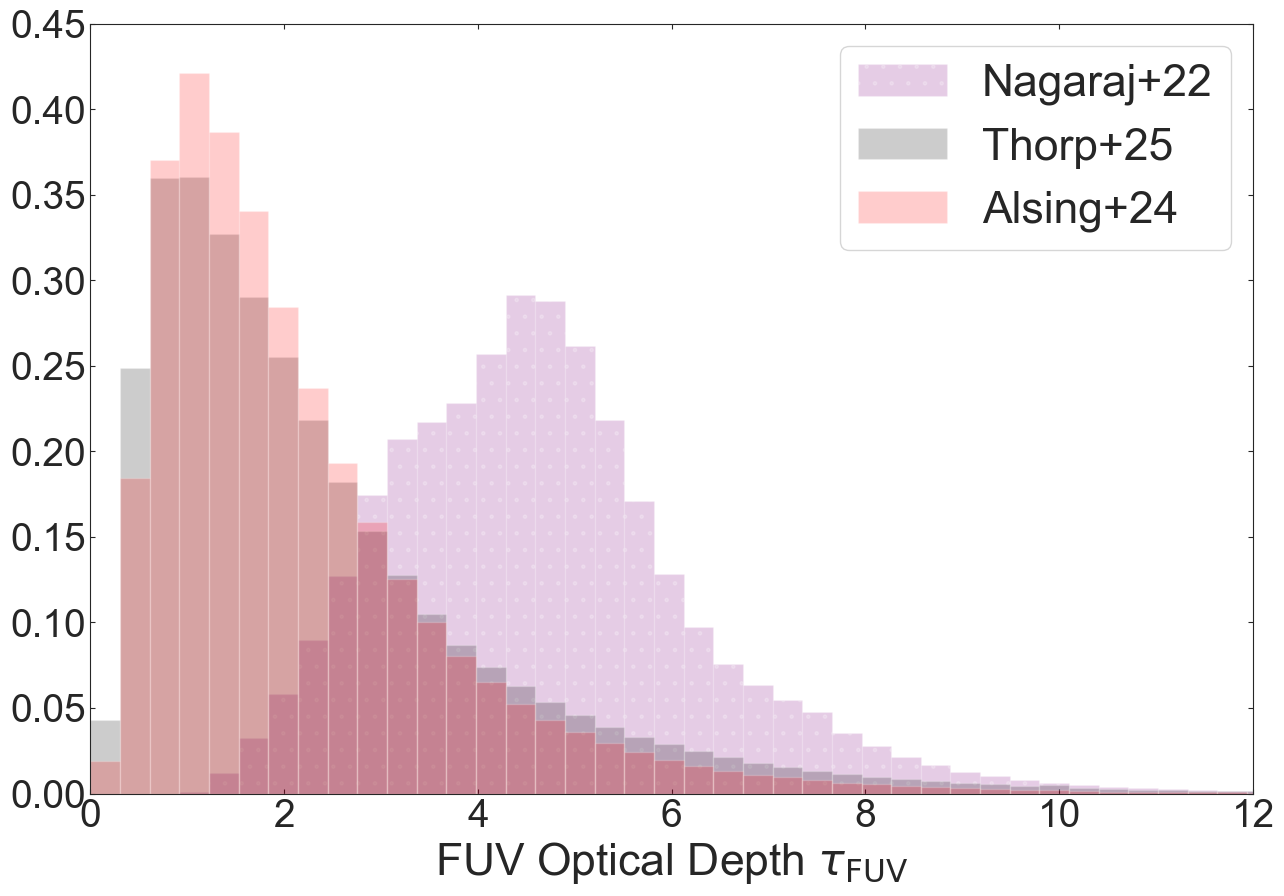

In [18]:
plot_tau_total()

plt.xlim(0, 12)

fig = plt.gcf()
fig.set_size_inches(15, 10)

fs=32
ls=28

plt.tick_params('x', labelsize=ls)
plt.tick_params('y', labelsize=ls)

plt.xlabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper right', fontsize=fs, ncol=1, frameon=True)
plt.ylim(0, 0.45)

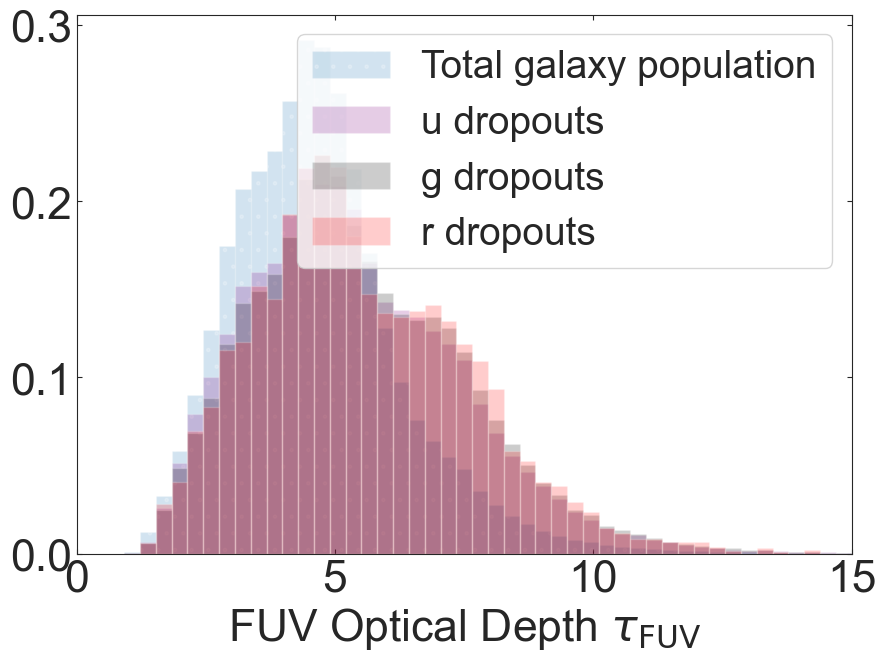

In [19]:
plot_tau_hist(spsp_nag, selected_spsp_nag)

plt.xlim(0, 15)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper right', fontsize=ls, ncol=1)

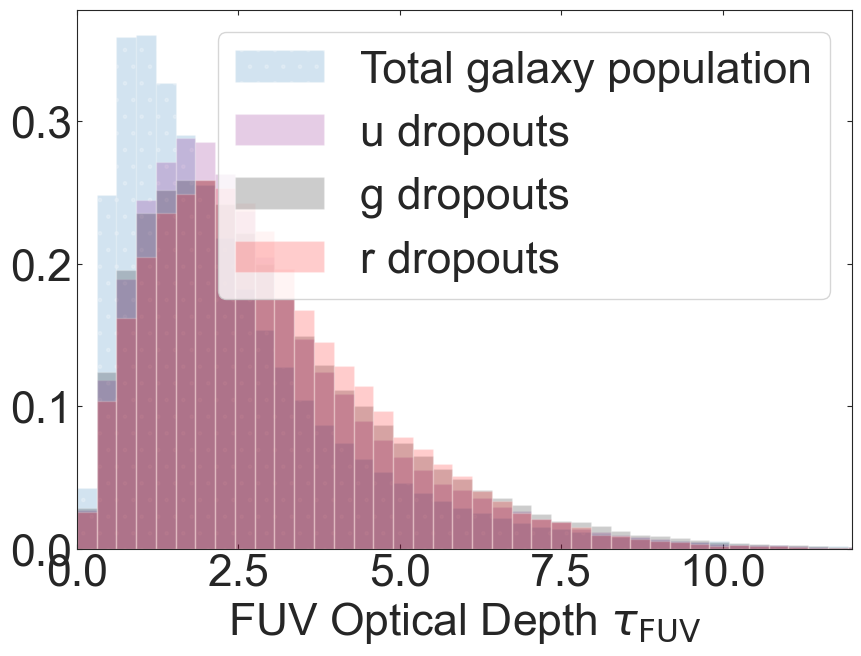

In [20]:
plot_tau_hist(spsp_irac, selected_spsp_irac)

plt.xlim(0, 12)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper right', fontsize=fs, ncol=1)

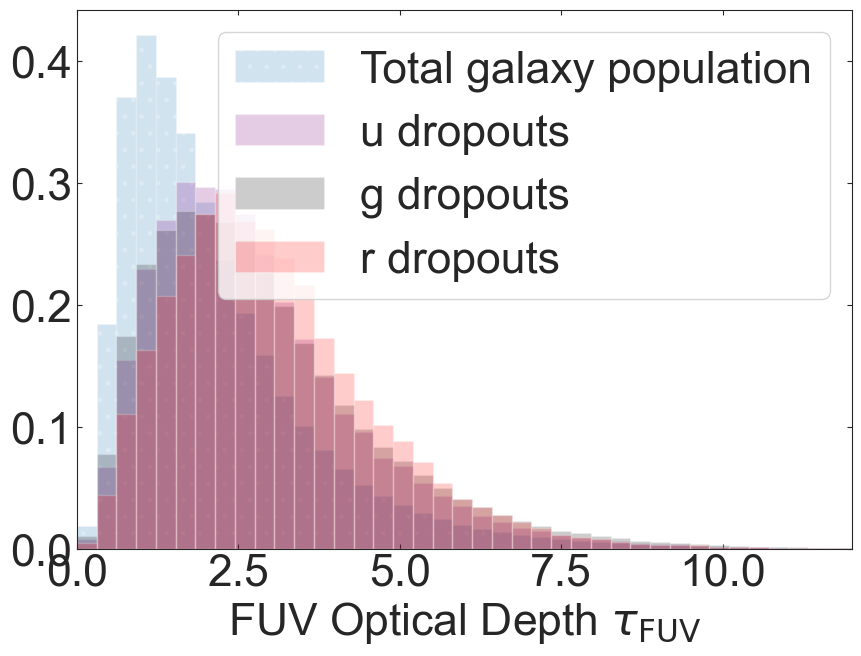

In [21]:
plot_tau_hist(spsp_cosmos, selected_spsp_cosmos)

plt.xlim(0, 12)

fig = plt.gcf()
fig.set_size_inches(10, 7)

plt.tick_params('x', labelsize=fs)
plt.tick_params('y', labelsize=fs)

plt.xlabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)
plt.legend(loc='upper right', fontsize=fs, ncol=1)

In [60]:
from getdist import plots
from getdist import MCSamples

def get_sfr_and_tauuv_mcsamples(spsp, cut=999999999):
    
    _, _, _, tuv, _ = pop.get_dust_params_from_pop(spsp, cut=cut)
    recent_sfrs = pop.get_sfr_params_from_pop(spsp, cut=cut)

    return MCSamples(samples=np.vstack((recent_sfrs, tuv)).T, names=['sfrs', 'tuv'], labels=['sfrs', 'tuv'])

def get_sfr_and_tauuv_z_mcsamples(spsp, cut=999999999):
    
    _, _, _, tuv, _ = pop.get_dust_params_from_pop(spsp, cut=cut)
    recent_sfrs = pop.get_sfr_params_from_pop(spsp, cut=cut)
    redshift = pop.get_redshift_from_pop(spsp, cut=cut)

    return MCSamples(samples=np.vstack((recent_sfrs, tuv, redshift)).T, names=['sfrs', 'tuv', 'z'], labels=['sfrs', 'tuv', 'z'])


def plot_3d_combined(selected_spsp1, selected_spsp2):

    #recent_sfrs = get_sfr_params_from_pop(np.squeeze(selected_spsp[indx, 0]))
    indx=0
    #samples_total = get_sfr_and_tauuv_z_mcsamples(spsp[indx], cut=cut)
    samples_u1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[0])
    samples_g1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[1])
    samples_r1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[2])

    samples_u2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[0])
    samples_g2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[1])
    samples_r2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[2])

    g=plots.get_subplot_plotter()
    g.rectangle_plot(['sfrs', 'tuv'], 'z', roots=[samples_u1, samples_u2, samples_g1, samples_g2, samples_r1, samples_r2],
                    line_args=[
                               {'ls':'-', 'color':'black', 'alpha':1.0, 'lw':3},
                                {'ls':'--', 'color':'purple', 'alpha':1.0, 'lw':2},
                               {'ls':'-', 'color':'black', 'alpha':0.75, 'lw':3},
                                {'ls':'--', 'color':'purple', 'alpha':0.75, 'lw':2},
                               {'ls':'-', 'color':'black', 'alpha':0.5, 'lw':3},
                               {'ls':'--', 'color':'purple', 'alpha':0.5, 'lw':2}], 
                    param_limits={'sfrs':(-5, 4), 'tuv':(0, 11)})



    fs=32

    fig = plt.gcf()
    fig.set_size_inches(15, 7)

def plot_3d(selected_spsp1, axis):

    #recent_sfrs = get_sfr_params_from_pop(np.squeeze(selected_spsp[indx, 0]))
    indx=0
    #samples_total = get_sfr_and_tauuv_z_mcsamples(spsp[indx], cut=cut)
    samples_u1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[0])
    samples_g1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[1])
    samples_r1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[2])

    g=plots.get_single_plotter()
    g.plot_2d([samples_u1, samples_g1, samples_r1], 'sfrs', 'z',
                   line_args=[
                               {'ls':'--', 'color':'purple', 'alpha':1.0, 'lw':3},
                                {'ls':'-.', 'color':'black', 'alpha':1.0, 'lw':3},
                               {'ls':'-', 'color':'red', 'alpha':1.0, 'lw':3}], 
                    param_limits={'sfrs':(-5, 4)}, ax=axis)



    fs=24
    ls=20

    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    #ax=plt.gca()

    axis.tick_params('x', labelsize=ls)
    axis.tick_params('y', labelsize=ls)

    axis.set_xlim(-5, 4)

    axis.set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[M$_{\odot}$yr$^{-1}$])', fontsize=fs, labelpad=25)
    axis.set_ylabel('Redshift $z$', fontsize=fs)

    g.add_legend(['u dropouts', 'g dropouts', 'r dropouts'], colored_text=False, fontsize=ls, ncols=1, ax=axis, legend_loc='upper left')

    return fig, ax


def plot_combined(selected_spsp1, selected_spsp2):

    indx=0
    samples_u1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[0])
    samples_g1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[1])
    samples_r1 = get_sfr_and_tauuv_z_mcsamples(selected_spsp1[2])

    samples_u2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[0])
    samples_g2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[1])
    samples_r2 = get_sfr_and_tauuv_z_mcsamples(selected_spsp2[2])

    g=plots.get_subplot_plotter()
    g.rectangle_plot('sfrs', 'tuv', roots=[samples_u1, samples_u2, samples_g1, samples_g2, samples_r1, samples_r2],
                    line_args=[
                               {'ls':'-', 'color':'black', 'alpha':1.0, 'lw':3},
                                {'ls':'--', 'color':'purple', 'alpha':1.0, 'lw':2},
                               {'ls':'-', 'color':'black', 'alpha':0.75, 'lw':3},
                                {'ls':'--', 'color':'purple', 'alpha':0.75, 'lw':2},
                               {'ls':'-', 'color':'black', 'alpha':0.5, 'lw':3},
                               {'ls':'--', 'color':'purple', 'alpha':0.5, 'lw':2}], 
                    param_limits={'sfrs':(-5, 4), 'tuv':(0, 14)})



    fs=32

    fig = plt.gcf()
    fig.set_size_inches(15, 7)

def plot_2d_density(spsp, selected_spsp, cut=999999999):

    #recent_sfrs = get_sfr_params_from_pop(np.squeeze(selected_spsp[indx, 0]))
    indx=0
    samples_total = get_sfr_and_tauuv_mcsamples(spsp, cut=cut)
    samples_u = get_sfr_and_tauuv_mcsamples(selected_spsp[0])
    samples_g = get_sfr_and_tauuv_mcsamples(selected_spsp[1])
    samples_r = get_sfr_and_tauuv_mcsamples(selected_spsp[2])

    g=plots.get_single_plotter()
    g.plot_2d([samples_total, samples_u, samples_g, samples_r], 'sfrs', 'tuv', shaded=True,
                    line_args=[{'ls':':', 'color':'blue', 'lw':3},
                               {'ls':'--', 'color':'purple', 'lw':3},
                               {'ls':'-.', 'color':'black', 'lw':3},
                               {'ls':'-', 'color':'red', 'lw':3}])



    fs=32
    ls=28

    fig = plt.gcf()
    fig.set_size_inches(15, 10)

    ax=plt.gca()

    ax.tick_params('x', labelsize=ls)
    ax.tick_params('y', labelsize=ls)

    ax.set_xlim(-5, 4)

    ax.set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[M$_{\odot}$yr$^{-1}$])', fontsize=fs, labelpad=25)
    ax.set_ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)

    g.add_legend(['Total Population', 'u dropouts', 'g dropouts', 'r dropouts'], colored_text=False, fontsize=ls, ncols=1, legend_loc='upper left')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


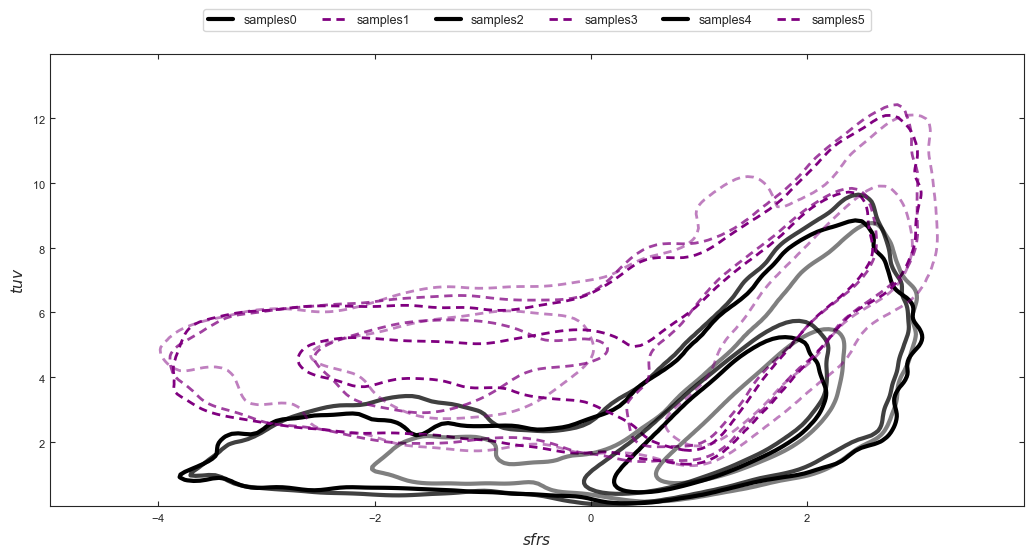

In [23]:
plot_combined(selected_spsp_cosmos, selected_spsp_nag)

Removed no burn in
Removed no burn in
Removed no burn in


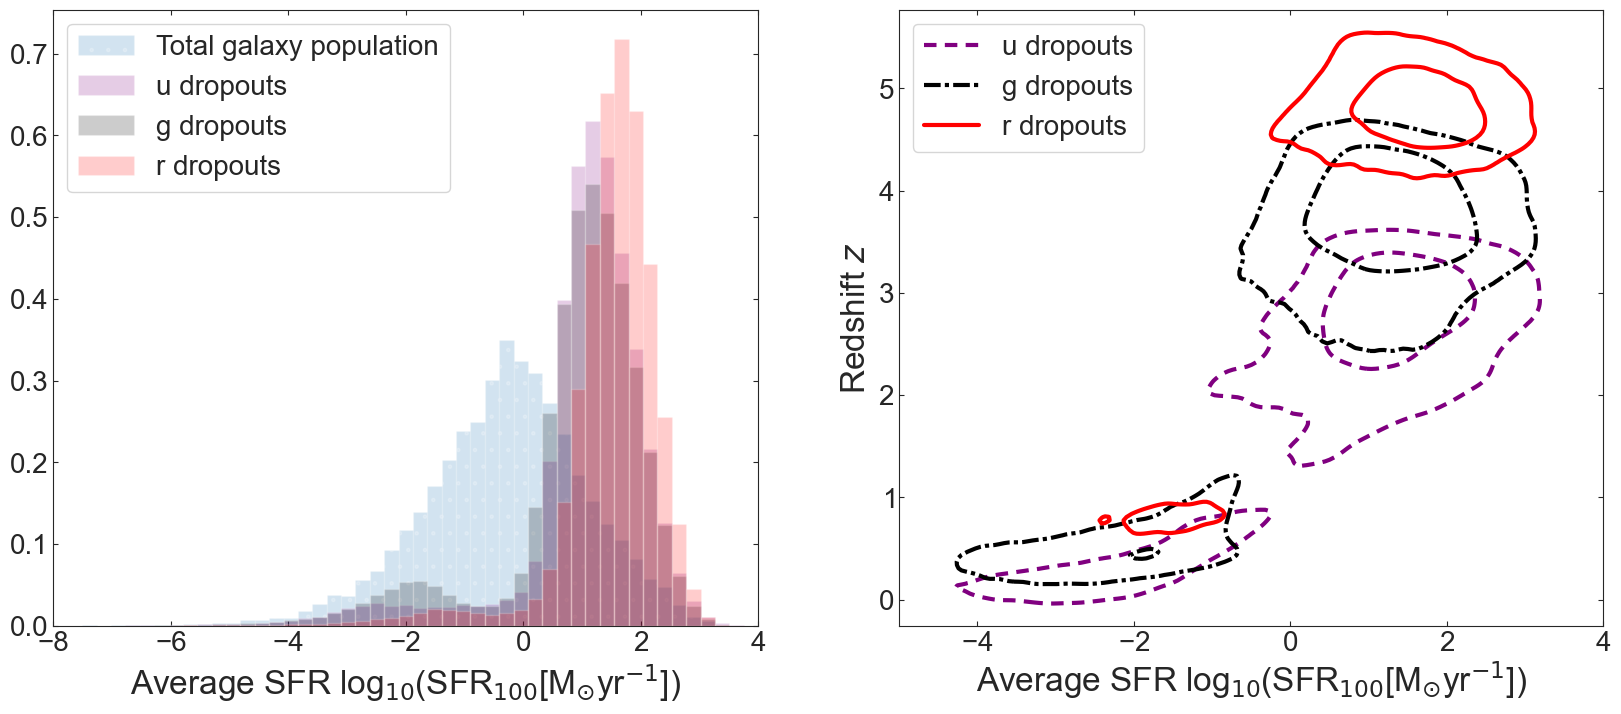

<Figure size 1500x1000 with 0 Axes>

In [86]:
f, a = plt.subplots(1, 2)

fig, ax = plot_3d(selected_spsp_cosmos, a[1])

plt_sfr_hist(spsp_cosmos, selected_spsp_cosmos, axis=a[0], cut=10000)

fs=24
ls=20

f.set_size_inches(20, 8)

a[0].tick_params('x', labelsize=ls)
a[0].tick_params('y', labelsize=ls)

a[0].set_xlim(-8, 4)

a[0].set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[M$_{\odot}$yr$^{-1}$])', fontsize=fs)
a[0].legend(loc='upper left', fontsize=ls, ncol=1)
#ax.set_ylabel('FUV Optical Depth $\\tau_{\mathrm{FUV}}$', fontsize=fs)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


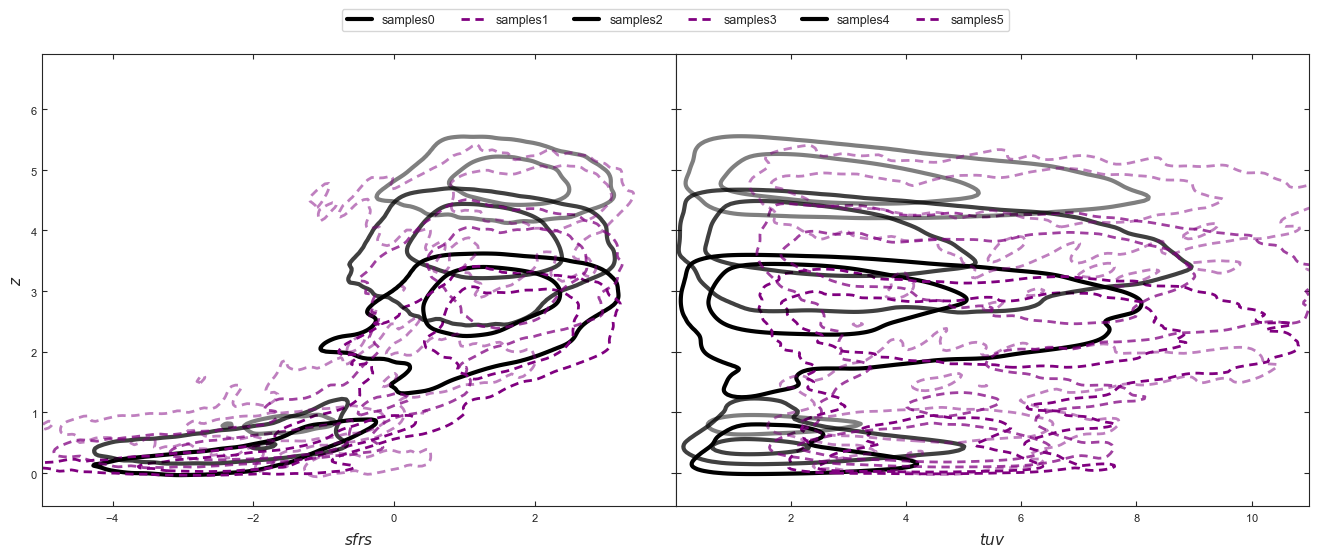

In [33]:
plot_3d_combined(selected_spsp_cosmos, selected_spsp_nag)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


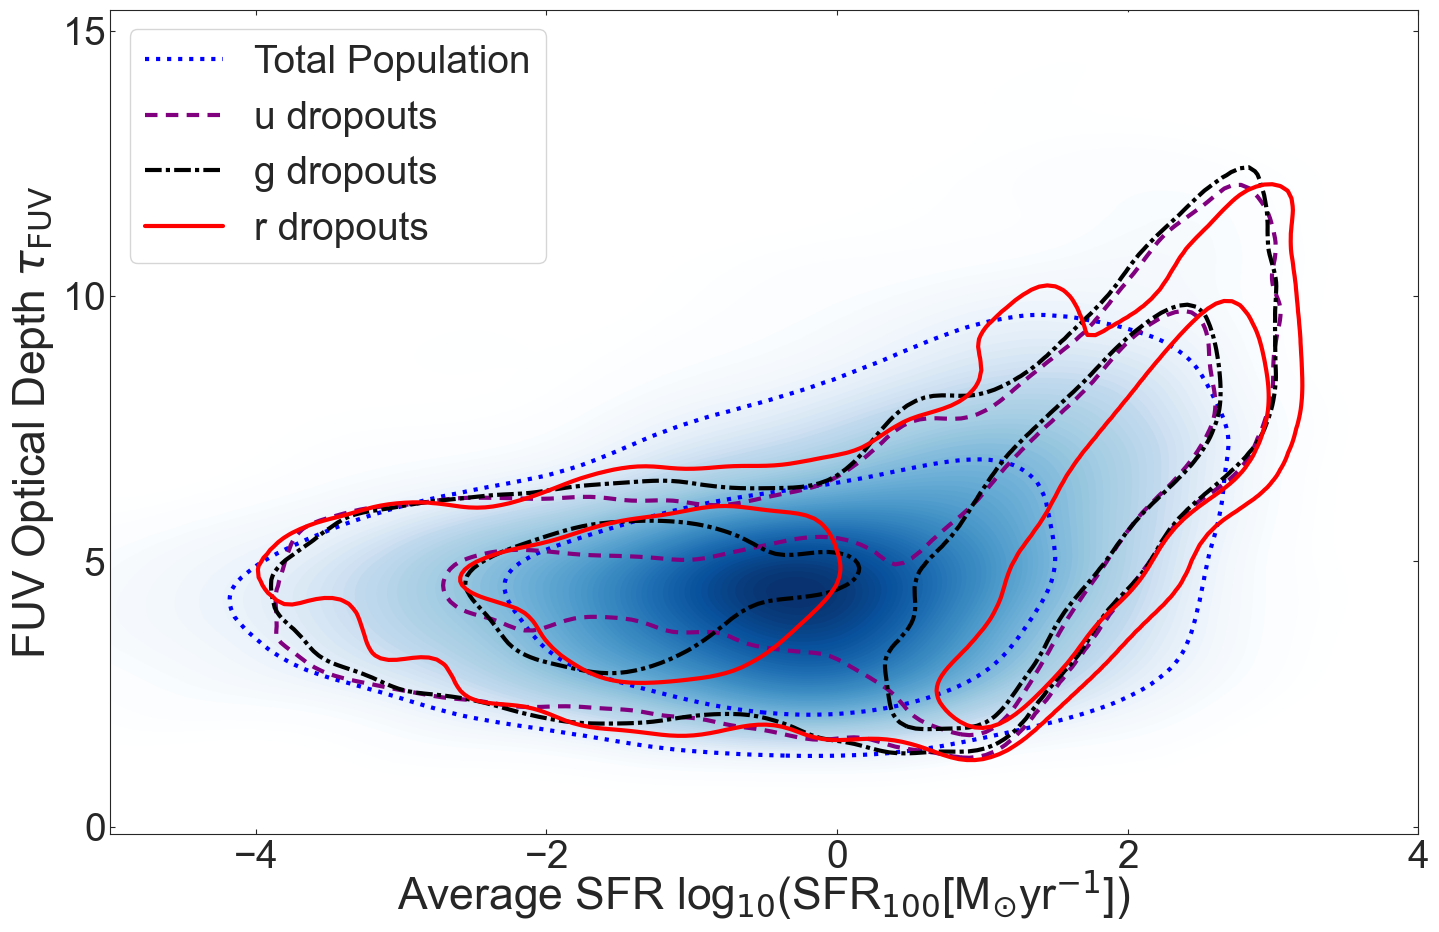

In [25]:
plot_2d_density(spsp_nag, selected_spsp_nag, cut=10000)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


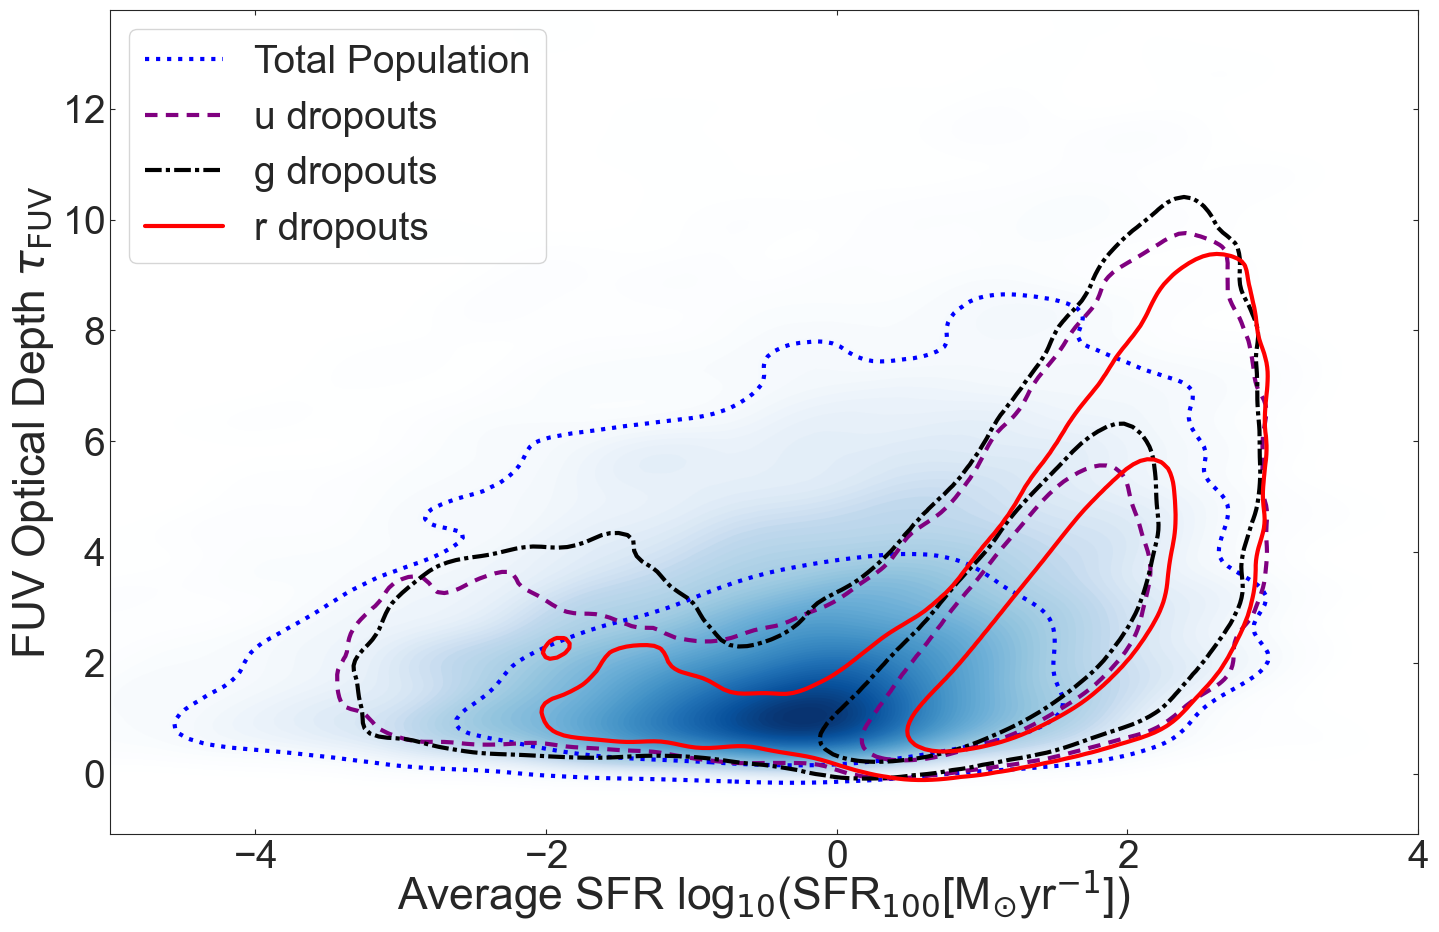

In [26]:
plot_2d_density(spsp_irac, selected_spsp_irac, cut=10000)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


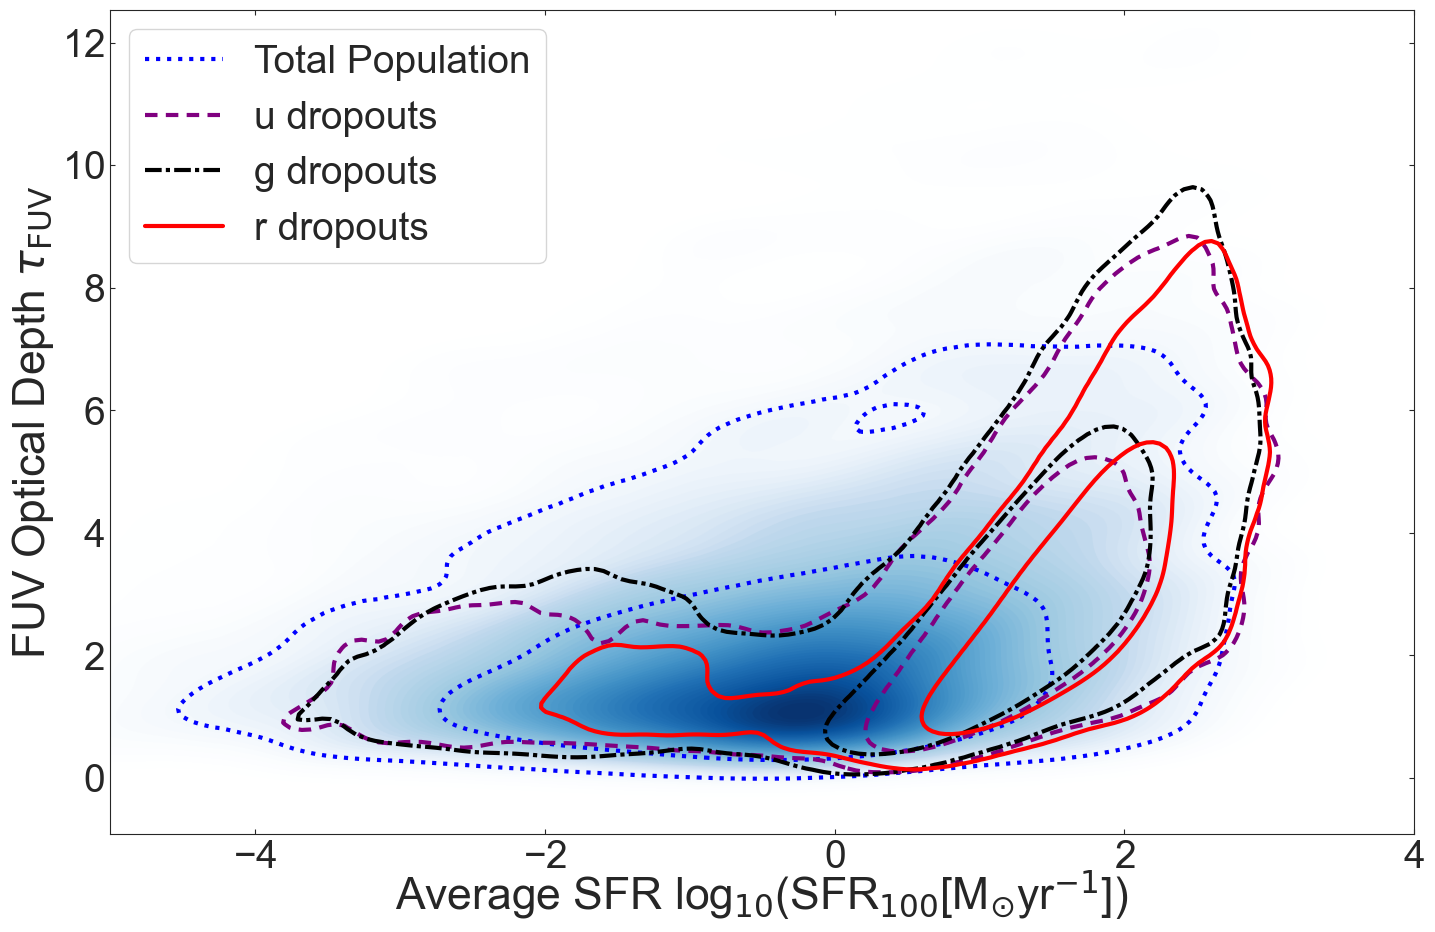

In [27]:
plot_2d_density(spsp_cosmos, selected_spsp_cosmos, cut=10000)